In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
#from stage_1_model_v1 import *
import stage_1_util_v1
from parse_lsp_data import *

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [47]:
from drawLines_v2 import drawLines

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4652545540158271045
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15768014029
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5699458612798731966
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 15868438119
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10917740344127115552
physical_device_desc: "device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:05.0, compute capability: 6.0"
]


In [4]:
from stage_1_modelClass_v1 import *
tfe.enable_eager_execution()

In [5]:
train_list, train_label, val_list, val_label, test_list, test_label = getLSPDataset(0.8, 0.1)
train_X = train_list	# (N, 227, 227, 3)
train_Y = train_label	# (N, 2, 14)
print("train X: ", train_list.shape, "val X: ", val_list.shape, "test X: ", test_list.shape)
print("train Y: ", train_label.shape, "val Y: ", val_label.shape, "test Y: ", test_label.shape)

Resizing and packing images and labels to lists.

Start to process training dataset
Done processing the training dataset
Start to process validation dataset
Done processing the validation dataset
Start to process test dataset
Done processing the test dataset
train X:  (1600, 227, 227, 3) val X:  (200, 227, 227, 3) test X:  (200, 227, 227, 3)
train Y:  (1600, 2, 14) val Y:  (200, 2, 14) test Y:  (200, 2, 14)


In [6]:
train_X = train_list
train_Y = train_label

n_samples = train_Y.shape[0] # N
n_joints = train_Y.shape[2]

# Parameters
learning_rate = 0.00005
batch_size = 128
display_step = 1
epochs = 250
if n_samples % batch_size == 0:
    n_batch = int(n_samples / batch_size)
else:
    n_batch = int(n_samples / batch_size) + 1
thresh = 0.5


#is_training = True

In [7]:
# don't use this', hinge
def loss(model, inputs, targets, is_training = True):
    predictions = model.predict(inputs, is_training)
    diff = tf.square(targets - predictions)
    #loss = tf.reduce_sum(diff)
    dist = tf.sqrt(tf.reduce_sum(diff, axis = 1))	# (N, 2, 14) -> (N, 14)
    loss = tf.reduce_sum(tf.maximum(dist - thresh, 0))
    #accuracy = tf.reduce_sum(tf.to_int32(tf.greater(thresh, dist))) * 1.0 / (int(dist.shape[0]) * int(dist.shape[1]))
    #loss = -(accuracy * accuracy)
    return loss

In [8]:
# use this, L2
def loss(model, inputs, targets, is_training = True):
    predictions = model.predict(inputs, is_training)
    loss = tf.reduce_sum(tf.square(predictions - targets))
    return loss

In [9]:
# don't use this. This is pixel accuracy
def loss_accuracy(model, inputs, targets, thresh, is_training):
    predictions = model.predict(inputs, is_training)
    diff = tf.square(targets - predictions)
    loss = tf.reduce_sum(diff)
    dist = tf.sqrt(tf.reduce_sum(diff, axis = 1))	# (N, 2, 14) -> (N, 14)

    accuracy = tf.reduce_sum(tf.to_int32(tf.greater(thresh, dist))) * 1.0 / (int(dist.shape[0]) * int(dist.shape[1]))
    return loss.numpy(), accuracy.numpy()

In [10]:
# use this. This is PDJ accuracy
def loss_accuracy(model, inputs, targets, thresh, is_training):
    predictions = model.predict(inputs, is_training)
    joint_diff = tf.square(targets - predictions)
    joint_dist = tf.sqrt(tf.reduce_sum(joint_diff, axis = 1))	# (N, 2, 14) -> (N, 14)
    loss = tf.reduce_sum(joint_diff)
    torsor_xy = targets[:, :, 9] - targets[:, :, 2] #distance left_shoulder <-> right_hip in xy, result (N, 2)
    torsor_dist = tf.sqrt(tf.reduce_sum(tf.square(torsor_xy), axis = 1, keep_dims = True)) # distance scaler, (N, 2) -> (N)
    torsor_frac = torsor_dist * thresh # max error distance

    accuracy = tf.reduce_sum(tf.to_int32(tf.greater(torsor_frac, joint_dist))) * 1.0 / (int(joint_dist.shape[0]) * int(joint_dist.shape[1]))
    return loss.numpy(), accuracy.numpy()

In [11]:
def next_batch(batch, batch_size, X, Y):
    if batch < n_batch - 1:
        batch_X = X[batch * batch_size: (batch + 1) * batch_size, :, :, :]
        batch_Y = Y[batch * batch_size: (batch + 1) * batch_size, :, :]
    else:
        batch_X = X[batch * batch_size:, :, :, :]
        batch_Y = Y[batch * batch_size:, :, :]
    batch_X = tf.convert_to_tensor(batch_X, np.float32)
    batch_Y = tf.convert_to_tensor(batch_Y, np.float32)
    #print(batch_X.shape, batch_Y.shape)
    return batch_X, batch_Y

In [12]:
def shuffle(X, Y):
    image_indexes = list(range(Y.shape[0]))
    np.random.shuffle(image_indexes)
    train_X_new = X[np.asarray(image_indexes)]
    train_Y_new = Y[np.asarray(image_indexes)]
    #print(image_indexes)
    #print(train_X_new[:, 0, :, :])
    #print(train_Y_new[:, 0, :])
    return train_X_new, train_Y_new

In [13]:
model = stage_1_model(n_joints)

In [14]:
# Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

In [15]:
# Compute gradients
grad = tfe.implicit_gradients(loss)

In [17]:
# Training
# is_training = False for no dropout
costs = []
train_acc_list = []
val_acc_list = []
loss_incr_max = 0.0
params = stage_1_util_v1.params
train_X_s, train_Y_s = train_X, train_Y

for epoch in range(epochs):
    with tf.device('/device:GPU:0'):
        batch_cost = 0.0
        
        train_X_s, train_Y_s = shuffle(train_X_s, train_Y_s)
        
        for batch in range(n_batch):
            #print("epoch: ", epoch, "batch: ", batch)
            batch_X, batch_Y = next_batch(batch, batch_size, train_X_s, train_Y_s)
            if batch == 0 and epoch == 0:
                ini_loss = loss(model, batch_X, batch_Y, is_training = True).numpy() / int(batch_Y.shape[0])
                print('initial loss: ', ini_loss)
            #pred = stage_1_model(batch_X, n_joints, is_training, params) # (N, 2, # joints)
            optimizer.apply_gradients(grad(model, batch_X, batch_Y))
            batch_cost += loss(model, batch_X, batch_Y, is_training = True)

        batch_cost = batch_cost / n_samples
        costs.append(batch_cost)
        if epoch > 2:
            incre = ((costs[-1] - costs[-2]) / costs[-2]).numpy()
            print('loss increase percent: ', incre)
            if incre > loss_incr_max:
                loss_incr_max = incre

        if epoch % display_step == 0:
            print("Epoch:", epoch, "cost", batch_cost.numpy())
            
        tr_X = tf.convert_to_tensor(train_list, np.float32)
        tr_Y = tf.convert_to_tensor(train_label, np.float32)
        _, train_acc = loss_accuracy(model, tr_X, tr_Y, thresh, is_training = False)
        print("train accuracy: ", train_acc)
        train_acc_list.append(train_acc)
        val_X = tf.convert_to_tensor(val_list, np.float32)
        val_Y = tf.convert_to_tensor(val_label, np.float32)
        val_loss, val_acc = loss_accuracy(model, val_X, val_Y, thresh, is_training = False)
        val_acc_list.append(val_acc)
        val_loss /= int(val_Y.shape[0])
        print("val loss: ", val_loss, "val accuracy: ", val_acc)

initial loss:  400328.40625
Epoch: 0 cost 110896.34
train accuracy:  0.2571428571428571
val loss:  62970.89 val accuracy:  0.25392857142857145
Epoch: 1 cost 49934.844
train accuracy:  0.37089285714285714
val loss:  46244.2 val accuracy:  0.3703571428571429
Epoch: 2 cost 44952.184
train accuracy:  0.4278571428571429
val loss:  39031.375 val accuracy:  0.42964285714285716
loss increase percent:  -0.057258237
Epoch: 3 cost 42378.3
train accuracy:  0.4517857142857143
val loss:  36561.7 val accuracy:  0.45785714285714285
loss increase percent:  -0.025364636
Epoch: 4 cost 41303.39
train accuracy:  0.4528125
val loss:  36108.065 val accuracy:  0.4567857142857143
loss increase percent:  -0.018540775
Epoch: 5 cost 40537.594
train accuracy:  0.4611160714285714
val loss:  35260.0175 val accuracy:  0.4725
loss increase percent:  -0.022091761
Epoch: 6 cost 39642.047
train accuracy:  0.45455357142857145
val loss:  35920.5 val accuracy:  0.45357142857142857
loss increase percent:  -0.0121550625
Epoch

train accuracy:  0.8721428571428571
val loss:  25455.6025 val accuracy:  0.6110714285714286
loss increase percent:  -0.024835922
Epoch: 56 cost 9139.293
train accuracy:  0.8696428571428572
val loss:  26124.055 val accuracy:  0.6142857142857143
loss increase percent:  -0.015315052
Epoch: 57 cost 8999.324
train accuracy:  0.8785714285714286
val loss:  25987.4725 val accuracy:  0.6110714285714286
loss increase percent:  -0.028685965
Epoch: 58 cost 8741.17
train accuracy:  0.8865178571428571
val loss:  26326.1025 val accuracy:  0.6107142857142858
loss increase percent:  -0.04262773
Epoch: 59 cost 8368.554
train accuracy:  0.8907589285714286
val loss:  25900.0125 val accuracy:  0.6171428571428571
loss increase percent:  -0.03581062
Epoch: 60 cost 8068.8706
train accuracy:  0.8905357142857143
val loss:  26103.4125 val accuracy:  0.6167857142857143
loss increase percent:  -0.0068464554
Epoch: 61 cost 8013.6274
train accuracy:  0.9010267857142857
val loss:  25973.225 val accuracy:  0.620714285

train accuracy:  0.9877678571428572
val loss:  25979.445 val accuracy:  0.6107142857142858
loss increase percent:  0.014370244
Epoch: 111 cost 3696.5076
train accuracy:  0.9924553571428572
val loss:  25941.79 val accuracy:  0.62
loss increase percent:  -0.042853873
Epoch: 112 cost 3538.098
train accuracy:  0.9915178571428571
val loss:  25892.725 val accuracy:  0.6228571428571429
loss increase percent:  3.0913503e-05
Epoch: 113 cost 3538.2073
train accuracy:  0.99375
val loss:  25273.4175 val accuracy:  0.6246428571428572
loss increase percent:  -0.0539041
Epoch: 114 cost 3347.4834
train accuracy:  0.9945982142857143
val loss:  25519.99 val accuracy:  0.6157142857142858
loss increase percent:  -0.0030656483
Epoch: 115 cost 3337.2212
train accuracy:  0.9944642857142857
val loss:  25665.655 val accuracy:  0.62
loss increase percent:  0.033896208
Epoch: 116 cost 3450.3403
train accuracy:  0.9909821428571428
val loss:  26451.495 val accuracy:  0.6078571428571429
loss increase percent:  -0.0

train accuracy:  0.9941071428571429
val loss:  25752.525 val accuracy:  0.6182142857142857
loss increase percent:  0.054034207
Epoch: 166 cost 3070.6106
train accuracy:  0.9969196428571429
val loss:  25693.0775 val accuracy:  0.6178571428571429
loss increase percent:  -0.1226383
Epoch: 167 cost 2694.0361
train accuracy:  0.9973214285714286
val loss:  25942.2325 val accuracy:  0.6167857142857143
loss increase percent:  -0.027431106
Epoch: 168 cost 2620.1357
train accuracy:  0.9977678571428571
val loss:  25076.49 val accuracy:  0.6289285714285714
loss increase percent:  0.015627917
Epoch: 169 cost 2661.083
train accuracy:  0.9978571428571429
val loss:  25283.205 val accuracy:  0.6242857142857143
loss increase percent:  -0.030138547
Epoch: 170 cost 2580.8818
train accuracy:  0.9980357142857142
val loss:  25472.7125 val accuracy:  0.6278571428571429
loss increase percent:  0.043589752
Epoch: 171 cost 2693.3818
train accuracy:  0.9964732142857143
val loss:  25264.88 val accuracy:  0.6289285

loss increase percent:  -0.03500657
Epoch: 220 cost 2201.6711
train accuracy:  0.99875
val loss:  25295.2 val accuracy:  0.6189285714285714
loss increase percent:  0.015075884
Epoch: 221 cost 2234.8633
train accuracy:  0.9977678571428571
val loss:  26116.37 val accuracy:  0.6128571428571429
loss increase percent:  0.015066419
Epoch: 222 cost 2268.5347
train accuracy:  0.9985267857142858
val loss:  25149.56 val accuracy:  0.6257142857142857
loss increase percent:  -0.02447557
Epoch: 223 cost 2213.011
train accuracy:  0.9982589285714286
val loss:  25472.17 val accuracy:  0.6164285714285714
loss increase percent:  -0.015029853
Epoch: 224 cost 2179.7498
train accuracy:  0.9977232142857143
val loss:  25848.1625 val accuracy:  0.6157142857142858
loss increase percent:  0.024883362
Epoch: 225 cost 2233.9893
train accuracy:  0.9982142857142857
val loss:  24987.295 val accuracy:  0.6289285714285714
loss increase percent:  -0.006415443
Epoch: 226 cost 2219.6572
train accuracy:  0.9984375
val los

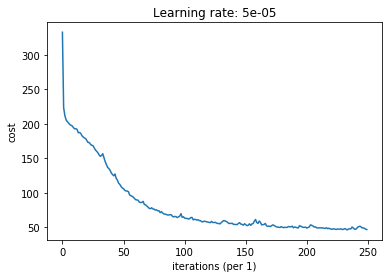

In [18]:
fig = plt.figure()
plt.plot(np.squeeze(np.sqrt(costs)))
plt.ylabel('cost')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("Learning rate: " + str(learning_rate))
fig.savefig('AlexNet_cost.png')
plt.show()

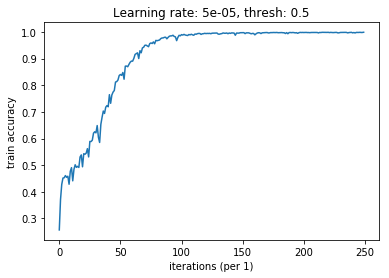

In [19]:
fig = plt.figure()
plt.plot(np.squeeze(train_acc_list))
plt.ylabel('train accuracy')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("Learning rate: " + str(learning_rate) + ", thresh: " + str(thresh))
fig.savefig('AlexNet_train_accuracy.png')
plt.show()

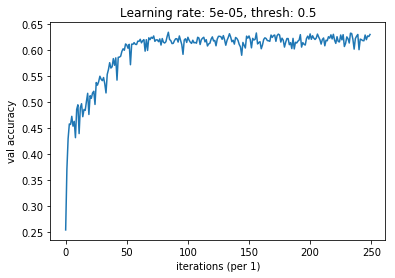

In [20]:
fig = plt.figure()
plt.plot(np.squeeze(val_acc_list))
plt.ylabel('val accuracy')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("Learning rate: " + str(learning_rate) + ", thresh: " + str(thresh))
fig.savefig('AlexNet_val_accuracy.png')
plt.show()

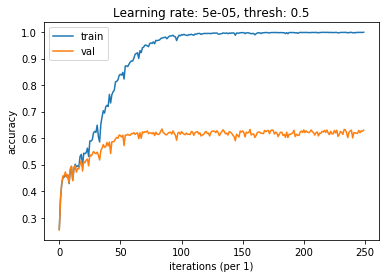

In [21]:
fig = plt.figure()
plt.plot(range(len(val_acc_list)), np.squeeze(train_acc_list), label = "train")
plt.plot(range(len(val_acc_list)), np.squeeze(val_acc_list), label = "val")
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("Learning rate: " + str(learning_rate) + ", thresh: " + str(thresh))
fig.savefig('AlexNet_accuracy.png')
plt.show()

In [45]:
with tf.device('/device:GPU:0'):
    one = train_list[0, :, :, :]
    one_1 = tf.convert_to_tensor(one, np.float32)
    one_1 = tf.reshape(one_1, [1, one_1.shape[0], one_1.shape[1], one_1.shape[2]])
    predictions_one = model.predict(one_1, is_training = False)
    print(predictions_one)
    print(train_label[0, :, :])

tf.Tensor(
[[[ 49.954407  86.64648   78.82301  125.455696 166.57108  102.23809
   127.1616    62.04128   92.77092  166.44807  144.93166  167.24724
   139.88994  149.16069 ]
  [205.28647  163.09756  115.52023  116.364555 157.78563  192.53467
    76.68863   77.89675   52.10197   52.181744  79.93448   85.76241
    46.22117   17.460623]]], shape=(1, 2, 14), dtype=float32)
[[ 50.20740877  83.82652876  85.02721161 130.65316017 172.67706016
  105.43882018 130.65316017  61.01355448  95.83335733 170.27569445
  142.65998874 173.87774302 141.45930588 151.06476874]
 [206.30842279 161.39537968 115.06402995 115.53679882 160.92261081
  191.65258767  83.38851533  84.80682196  53.60407622  53.60407622
   74.87867558  87.64343521  47.45808084  19.56471723]]


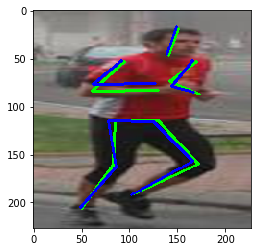

In [48]:
drawLines(train_list[0].copy(),train_label[0].copy(),predictions_one[0])

In [44]:
print(predictions_one)

tf.Tensor(
[[[153.24092  133.77351  123.53111  107.90918  108.600296 108.28839
   165.73724  151.98843  125.978264  94.58561   83.99324   89.21388
   109.892654 114.60832 ]
  [203.59497  156.61559  114.82439  114.44308  162.23013  193.1665
    75.044785  68.51921   52.619717  52.474506  74.24512   83.511246
    44.82616   22.766634]]], shape=(1, 2, 14), dtype=float32)


In [49]:
with tf.device('/device:GPU:0'):
    one = val_list[4, :, :, :]
    one_1 = tf.convert_to_tensor(one, np.float32)
    one_1 = tf.reshape(one_1, [1, one_1.shape[0], one_1.shape[1], one_1.shape[2]])
    predictions_one = model.predict(one_1, is_training = False)
    print(predictions_one)
    print(val_label[0, :, :])

tf.Tensor(
[[[153.24092  133.77351  123.53111  107.90918  108.600296 108.28839
   165.73724  151.98843  125.978264  94.58561   83.99324   89.21388
   109.892654 114.60832 ]
  [203.59497  156.61559  114.82439  114.44308  162.23013  193.1665
    75.044785  68.51921   52.619717  52.474506  74.24512   83.511246
    44.82616   22.766634]]], shape=(1, 2, 14), dtype=float32)
[[140.53429463 148.19680844 123.11949051  82.71714497  98.04217259
  105.00809423 114.76038454  77.84099982  98.73876475  98.73876475
   75.75122332 133.56837298 109.88423939 123.81608268]
 [213.29073205 169.58454938 125.2713364  124.36079093 165.94236749
  207.52394406 128.91351829  88.84951751  45.44685     46.96442579
   83.99327499  76.1018809   38.46600138  12.667213  ]]


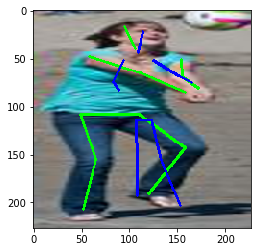

In [50]:
drawLines(val_list[5].copy(),val_label[5].copy(),predictions_one[0])

In [ ]:
print(loss_incr_max)